<a href="https://colab.research.google.com/github/gulabpatel/Graph_Neural_Network/blob/main/GNN_AnomalyDetection/Explainable_Fraud_Detection_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [ ]:
!pip install xgbfir
!pip install numba
!pip install parfit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from numba import jit
from math import log
import numpy as np
from bisect import bisect_right
import xgboost as xgb
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
import parfit.parfit as pf
try:
    from StringIO import StringIO ## for Python 2
except ImportError:
    from io import StringIO ## for Python 3
from IPython.display import Image
from sklearn.tree import export_graphviz
from IPython.display import Image, display
import pydotplus
import os
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
import joblib
import xgbfir
import itertools

np.random.seed(42)

from google.colab import drive

pd.options.display.max_rows = 4000
pd.options.display.max_seq_items = 2000
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

drive.mount('/mntDrive', force_remount = True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /mntDrive


# **Load Data**

In [ ]:
path = '..'
file_train = '..'
file_test = '..'
train = pd.read_csv(path + file_train).sample(frac=0.5)
test = pd.read_csv(path + file_test).sample(frac=0.5)

# **Useful functions**



*   **MDLP functions** - supervised discretization of numeric variables according to Minimum-Description Length Principle (https://www.ijcai.org/Proceedings/93-2/Papers/022.pdf)
*   **encode_data_ohe** - one-hot encoding for train and test preserving same columns, missing values handling

*   **add_interactions** = dumping trained xgboost model, parsing and cleaning interactions, filtering only stable interactions by Gain Rank, assigning interactions of depth 2,3,4 to original dataframe (inspired by:

        1.   X He et al. 2014, “Practical Lessons from Predicting Clicks on Ads at Facebook” https://research.fb.com/wp-content/uploads/2016/11/practical-lessons-from-predicting-clicks-on-ads-at-facebook.pdf
        2.   JH Friedman et al. 2005 “Predictive Learning via Rule Ensembles”, https://statweb.stanford.edu/~jhf/ftp/RuleFit.pdf)


*   **eval_mcc, func_mcc, evalmcc, eval_mcc_sk(learn)** - functions to compute and optimizae MCC metric based on: https://www.kaggle.com/cpmpml/optimizing-probabilities-for-best-mcc

*   **draw_feature, get_variable, get_variables** - functions for exploring binary rulesets with Decision Tree (drawing, selecting top variables, selecting specific interactions).

In [ ]:
class MDLP(object):
    '''
    Entropy-based Minimum description length principle.
    '''
    def discretize_feature(self, x, binning):
        '''
        Discretize a feature x with respective to the given binning
        '''
        x_discrete = [1 for i in range(len(x))]
        for i in range(len(x)):
            for cut_value in binning:
                if x[i] > cut_value:
                    x_discrete[i] = x_discrete[i] + 1
        return np.array(x_discrete)

    def target_table(self, target):
        '''
        Create a numpy array that counts the occurrences
        of values of the input vector
        Example:
        target_table([1,2,2,3,4,5,5,5,5,6])
        >>> array([1,2,1,1,4,1])
        '''
        return np.unique(target, return_counts=True)[1]

    def stable_log(self, input):
        '''
        Stable version of natural logarithm, which
        replaces elements smaller than 1*e^(-10) by
        one to avoid infinite values, then applies log as usual.
        The input variable has to be a numpy array.
        Example:
        stable_log([0,1,2])
        >>> array([1,2,3,4,5,6])
        '''
        copy = input.copy()
        copy[copy <= 1e-10] = 1
        return np.log(copy)

    def entropy(self, variable):
        '''
        Compute the Shannon entropy of the input variable
        Example:
        stable_log(np.array([0,1,2]))
        >>> array([0., 0., 0.69314718])
        '''
        prob = self.target_table(variable) / len(variable)
        ent = -sum(prob * self.stable_log(prob))

        return ent

    def levels(self, variable):
        '''
        Create a numpy array that lists each value of the
        input vector once.
        Example:
        levels([1,2,2,3,4,5,5,5,5,6])
        >>> array([1,2,3,4,5,6])
        '''
        return np.unique(variable)

    def stopping_criterion(self, cut_idx, target, ent):
        '''
        Stopping criterion of the MDLP algorithm. Specifying a
        cutting index cut_idx, a target vector and the current entropy,
        the function will compute the entropy of the vector split by
        the cutting point.
        If the gain in further splitting, i.e. the decrease in entropy
        is too small, the algorithm will return "None" and MDLP will
        be stopped.
        '''
        n = len(target)
        target_entropy = self.entropy(target)
        gain = target_entropy - ent

        k = len(np.unique(target))
        k1 = len(np.unique(target[: cut_idx]))
        k2 = len(np.unique(target[cut_idx: ]))

        delta = (log(3**k - 2) - (k * target_entropy
                 - k1 * self.entropy(target[: cut_idx])
                 - k2 * self.entropy(target[cut_idx: ])))
        cond = log(n - 1) / n + delta / n
        if gain >= cond:
            return gain
        else:
            return None

    def find_cut_index(self, x, y):
        '''
        Determine the optimal cutting point (in the sense
        of minimizing entropy) for a feature vector x and
        a corresponding target vector y.
        The function will return the index of this point
        and the respective entropy.
        '''
        n = len(y)
        init_entropy = 9999
        current_entropy = init_entropy
        index = None
        for i in range(n - 1):
            if (x[i] != x[i+1]):
                cut = (x[i] + x[i + 1]) / 2.
                cutx = bisect_right(x, cut)
                weight_cutx = cutx / n
                left_entropy = weight_cutx * self.entropy(y[: cutx])
                right_entropy = (1 - weight_cutx) * self.entropy(y[cutx: ])
                temp = left_entropy + right_entropy
                if temp < current_entropy:
                    current_entropy = temp
                    index = i + 1
        if index is not None:
            return [index, current_entropy]
        else:
            return None

    def cut_points(self, x, y):
        '''
        Main function for the MDLP algorithm. A feature vector x
        and a target vector y are given as input, the algorithm
        computes a list of cut-values used for binning the variable x.
        '''
        sorted_index = np.argsort(x)
        xo = x[sorted_index]
        yo = y[sorted_index]
        depth = 1

        def getIndex(low, upp, depth=depth):
            x = xo[low:upp]
            y = yo[low:upp]
            cut = self.find_cut_index(x, y)
            if cut is None:
                return None
            cut_index = int(cut[0])
            current_entropy = cut[1]
            ret = self.stopping_criterion(cut_index, np.array(y),
                                          current_entropy)
            if ret is not None:
                return [cut_index, depth + 1]
            else:
                return None

        def part(low=0, upp=len(xo)-1, cut_points=np.array([]), depth=depth):
            x = xo[low: upp]
            if len(x) < 2:
                return cut_points
            cc = getIndex(low, upp, depth=depth)
            if (cc is None):
                return cut_points
            ci = int(cc[0])
            depth = int(cc[1])
            cut_points = np.append(cut_points, low + ci)
            cut_points = cut_points.astype(int)
            cut_points.sort()
            return (list(part(low, low + ci, cut_points, depth=depth))
                    + list(part(low + ci + 1, upp, cut_points, depth=depth)))

        res = part(depth=depth)
        cut_index = None
        cut_value = []
        if res is not None:
                cut_index = res
                for indices in cut_index:
                        cut_value.append((xo[indices-1] + xo[indices])/2.0)
        result = np.unique(cut_value)
        return result

def readable_cut_points(variable, binning):

    values = set(variable)
    binning = np.round(binning,2)
    dicts = {}

    for i in range(1, len(values)):

          dicts[i] = 'btw_'+str(binning[i-2])+'_and_'+str(binning[i-1])

          if (i == 1):
            dicts[i] = 'lt_'+str(binning[i-1])

          if (i + 1 == len(values)):
              dicts[i + 1] = 'gt_'+str(binning[i-1])

    return dicts

def encode_float_mdlp(X_train, X_test, Y_train, use_features, numeric_col, cat_col):

    X_tr = X_train.copy()
    X_te = X_test.copy()

    mdlp = MDLP()

    for col in tqdm(numeric_col):
          var_tr = X_tr[col].values
          var_te = X_te[col].values
          target = np.array(Y_train.astype('int'))
          binning = mdlp.cut_points(var_tr, target)
          if (len(binning)==0):
              continue
          cat_col = cat_col.append(pd.Index([col]))
          ser_tr = pd.Series(mdlp.discretize_feature(var_tr, binning), index = X_train.index)
          ser_te = pd.Series(mdlp.discretize_feature(var_te, binning), index = X_test.index)
          X_tr[col] = ser_tr.map(readable_cut_points(ser_tr, binning))
          X_te[col] = ser_te.map(readable_cut_points(ser_te, binning))


    return X_tr, X_te, cat_col


def encode_data_ohe(X_train, X_test, Y_train, use_features, bool_col, cat_col):

    X_train_enc = X_train[use_features].copy()
    X_test_enc = X_test[use_features].copy()

    X_train_enc = X_train_enc.replace([np.inf, -np.inf], np.nan)
    X_test_enc = X_test_enc.replace([np.inf, -np.inf], np.nan)

    X_train_enc[cat_col]=X_train_enc[cat_col].fillna('N/A')
    X_test_enc[cat_col]=X_test_enc[cat_col].fillna('N/A')

    X_train_enc[bool_col]=X_train_enc[bool_col].fillna(-9999).astype('int')
    X_test_enc[bool_col]=X_test_enc[bool_col].fillna(-9999).astype('int')

    X_train_ohe = pd.get_dummies(X_train_enc[cat_col])
    X_test_ohe = pd.get_dummies(X_test_enc[cat_col])
    missing_cols = set(X_train_ohe.columns ) - set(X_test_ohe.columns)
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        X_test_ohe[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    X_test_ohe = X_test_ohe[X_train_ohe.columns]

    X_train_enc = pd.concat([X_train_enc, X_train_ohe], axis=1)
    X_test_enc = pd.concat([X_test_enc, X_test_ohe], axis=1)

    X_train_enc.drop(cat_col, axis=1, inplace=True)
    X_test_enc.drop(cat_col, axis=1, inplace=True)

    X_train_cols = X_train_enc.columns
    X_test_cols = X_test_enc.columns

    return X_train_enc, X_test_enc, X_train_cols, X_test_cols

def add_interactions(X_train_enc, X_test_enc, bst, gain_rank_filter):

      xgbfir.saveXgbFI(bst, MaxInteractionDepth=3)
      xl_file = pd.ExcelFile('XgbFeatureInteractions.xlsx')

      dfs = {sheet_name: xl_file.parse(sheet_name)
                for sheet_name in xl_file.sheet_names}

      interactions = list(dfs['Interaction Depth 1'][dfs['Interaction Depth 1']['Gain Rank']<gain_rank_filter]['Interaction'].unique()) + list(dfs['Interaction Depth 2'][dfs['Interaction Depth 2']['Gain Rank']<gain_rank_filter]['Interaction'].unique()) + list(dfs['Interaction Depth 3'][dfs['Interaction Depth 3']['Gain Rank']<gain_rank_filter]['Interaction'].unique())

      clean_interactions = []
      i = 0

      for var in interactions:

          var = list(set(var.split('|')))
          if (len(var) > 1):
            clean_interactions += [var]
          i = i + 1

      clean_interactions.sort()
      clean_interactions = list(clean_interactions for clean_interactions,_ in itertools.groupby(clean_interactions))

      for i in range(0, len(clean_interactions)):
        if (len(clean_interactions[i])==2):
            X_train_enc[clean_interactions[i][0]+'|'+clean_interactions[i][1]]=X_train_enc[clean_interactions[i][0]]*X_train_enc[clean_interactions[i][1]]
            X_test_enc[clean_interactions[i][0]+'|'+clean_interactions[i][1]]=X_test_enc[clean_interactions[i][0]]*X_test_enc[clean_interactions[i][1]]
        if (len(clean_interactions[i])==3):
            X_train_enc[clean_interactions[i][0]+'|'+clean_interactions[i][1]+'|'+clean_interactions[i][2]]=X_train_enc[clean_interactions[i][0]]*X_train_enc[clean_interactions[i][1]]*X_train_enc[clean_interactions[i][2]]
            X_test_enc[clean_interactions[i][0]+'|'+clean_interactions[i][1]+'|'+clean_interactions[i][2]]=X_test_enc[clean_interactions[i][0]]*X_test_enc[clean_interactions[i][1]]*X_test_enc[clean_interactions[i][2]]
        if (len(clean_interactions[i])==4):
            X_train_enc[clean_interactions[i][0]+'|'+clean_interactions[i][1]+'|'+clean_interactions[i][2]+'|'+clean_interactions[i][3]]=X_train_enc[clean_interactions[i][0]]*X_train_enc[clean_interactions[i][1]]*X_train_enc[clean_interactions[i][2]]*X_train_enc[clean_interactions[i][3]]
            X_test_enc[clean_interactions[i][0]+'|'+clean_interactions[i][1]+'|'+clean_interactions[i][2]+'|'+clean_interactions[i][3]]=X_test_enc[clean_interactions[i][0]]*X_test_enc[clean_interactions[i][1]]*X_test_enc[clean_interactions[i][2]]*X_test_enc[clean_interactions[i][3]]

      X_train_cols, X_test_cols = X_train_enc.columns, X_test_enc.columns

      return X_train_enc, X_test_enc, X_train_cols, X_test_cols

@jit
def func_mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

@jit
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = func_mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        # print(score, best_mcc)
        # plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc


def evalmcc(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    return 'MCC', best_mcc

def eval_mcc_sk(y_true, y_prob):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = func_mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0

    return best_mcc

def draw_feature(selected_cols, max_depth, min_samples_leaf):

        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(X_train_enc[selected_cols], Y_train)

        clf_tmp = DecisionTreeRegressor(max_depth=1, min_samples_leaf=min_samples_leaf)
        clf_tmp.fit(X_train_enc[selected_cols], Y_train)
        top_feature = np.array(selected_cols)[clf_tmp.feature_importances_ > 0]

        dot_data = StringIO()
        export_graphviz(clf, out_file=dot_data, feature_names = selected_cols,
                        filled=True, rounded=True, proportion = True, impurity = False,
                        special_characters=True,
                        class_names = ['GOOD', 'BAD']
                       )
        graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
        graph.write_png('original_tree.png')
        graph.set_size('"75,!"')
        plt = Image(graph.create_png())
        display(plt)
        return top_feature

def get_variables(coefficients, top = 10):
    var_list = coefficients.sort_values(by = 'weight', ascending = False).head(top)['variable'].unique()

    draw_interactions = []
    i = 0

    for var in var_list:

        var = list(set(var.split('|')))
        draw_interactions += var
        i = i + 1

    draw_interactions.sort()
    draw_interactions = list(set(draw_interactions))
    return draw_interactions

def get_variable(coefficients, num = 145):
    var_list = [coefficients.ix[num]['variable']]

    draw_interactions = []
    i = 0

    for var in var_list:

        var = list(set(var.split('|')))
        draw_interactions += var
        i = i + 1

    draw_interactions.sort()
    draw_interactions = list(set(draw_interactions))
    return draw_interactions

# **Define Useful Features**

In [ ]:
use_features =  ['first_digit', 'user_cnt_topups', 'user_mean_topups',
       'user_uniq_states', 'country', 'mean_time_to_tran_min', 'time_bin',
       'hour', 'dayofyear_hour_bin', 'last_digit', 'user_std_topups',
       'louvain_community', 'labelprop_community']

# **Define Train and Test Set**

In [ ]:
X = train.set_index('USER_ID')[use_features]
X_test = test.set_index('USER_ID')[use_features]
Y = train.set_index('USER_ID')['is_fraud']

# **Determine Boolean, Numeric and Category Types**

In [ ]:
bool_col = X.select_dtypes(include=['bool']).columns
numeric_col = X.select_dtypes(include=['float', 'int']).columns
cat_col = X.select_dtypes(include=['object']).columns

# **Split Data for Train and Validation Set**

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.33, random_state=42)

# **Encode numeric features with MDLP and then encode all features with One-Hot Encoding**

In [ ]:
X_train_enc, X_valid_enc, cat_col = encode_float_mdlp(X_train, X_valid, Y_train, use_features, numeric_col, cat_col)
X_train_enc, X_valid_enc, X_train_cols, X_valid_cols = encode_data_ohe(X_train_enc, X_valid_enc, Y_train, use_features, bool_col, cat_col)

100%|██████████| 12/12 [10:50<00:00, 54.22s/it]


# **Train First-Level XGBoost Model with CV (optimizing MCC)**

In [ ]:
dtrain = xgb.DMatrix(X_train_enc, label = Y_train)
dtest =  xgb.DMatrix(X_valid_enc, label = Y_valid)
# Setting variable monotonicity constraints
# 0: no constraint, 1: positive, -1: negative
feature_monotones = [1] * (len(X_train_cols))

params = {'max_depth': 4,
          'eta': 0.1,
          'silent': 1,
          'nthread': 4,
          'seed': 0,
          'tree_method': 'hist',
          'grow_policy': 'lossguide',
          'eval_metric': 'auc',
          # E.g. fitting three features with positive, negative and no constraint
          # 'monotone_constraints': (1,-1,0)
          'monotone_constraints': '(' + ','.join([str(m) for m in feature_monotones]) + ')'
         }

# Use CV to find the best number of trees
bst_cv = xgb.cv(params, dtrain, 500, nfold = 5, early_stopping_rounds=20, feval = evalmcc, maximize=True, verbose_eval=True)

# Train on the entire training set, evaluate performances on the testset
evallist  = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}
bst = xgb.train(params, dtrain, num_boost_round = bst_cv.shape[0], evals_result = evals_result, evals = evallist,  verbose_eval = True, feval = evalmcc, maximize=True)

[0]	train-MCC:0.278226+0.00887209	train-auc:0.816632+0.0164073	test-MCC:0.277132+0.0342163	test-auc:0.813552+0.0223384
[1]	train-MCC:0.278226+0.00887209	train-auc:0.83498+0.0128987	test-MCC:0.277132+0.0342163	test-auc:0.833506+0.0128824
[2]	train-MCC:0.307283+0.0216323	train-auc:0.836937+0.0137505	test-MCC:0.297905+0.0456273	test-auc:0.83657+0.0136879
[3]	train-MCC:0.353545+0.00582817	train-auc:0.841772+0.0108864	test-MCC:0.346859+0.0489823	test-auc:0.840134+0.0116647
[4]	train-MCC:0.355476+0.00748282	train-auc:0.851629+0.00718603	test-MCC:0.351855+0.0380861	test-auc:0.849522+0.010154
[5]	train-MCC:0.371221+0.0099941	train-auc:0.852611+0.00744284	test-MCC:0.365556+0.0426886	test-auc:0.850706+0.0106364
[6]	train-MCC:0.367726+0.00897306	train-auc:0.853195+0.00733947	test-MCC:0.358329+0.040984	test-auc:0.851132+0.0104167
[7]	train-MCC:0.369786+0.0073256	train-auc:0.854208+0.00639181	test-MCC:0.36467+0.0356561	test-auc:0.851474+0.0101524
[8]	train-MCC:0.371706+0.00581259	train-auc:0.855749

# **Save XGBoost Model**

In [ ]:
#save model
import joblib
joblib.dump(bst, 'model_first_level_xgb')
bst = joblib.load('model_first_level_xgb')

# **Add Interactions to Train and Valid Data**

In [ ]:
X_train_enc, X_valid_enc, X_train_cols, X_valid_cols = add_interactions(X_train_enc, X_valid_enc, bst, gain_rank_filter = 50)

# **Cross-Validate with Second-Level model**
**Find Best parameters for SGDClassifier and threshold for MCC**

In [ ]:
NFOLDS = 4
RANDOM_STATE = 42


clfs = []
mcc = []
thresholds = []
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=RANDOM_STATE)
oof_preds = np.zeros((len(X_train_enc), 1))
test_preds = np.zeros((len(X_valid_enc), 1))
# Y_train = Y_train.reset_index()

for fold_, (trn_, val_) in enumerate(folds.split(X_train_enc, Y_train)):
    print("Current Fold: {}".format(fold_))
    X_trn, Y_trn = X_train_enc.iloc[trn_, :], Y_train.iloc[trn_]
    X_val, Y_val = X_train_enc.iloc[val_, :], Y_train.iloc[val_]

    print('')

    # grid = {
    #     'alpha': [5e-6, 5e-5, 5e-4, 5e-3], # learning rate
    #     'max_iter': [1000, 2000, 3000], # number of epochs
    #     'loss': ['log'], # logistic regression,
    #     'n_jobs': [-1],
    #     'class_weight' : ['balanced']
    # }
    # paramGrid = ParameterGrid(grid)

    # bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
    #           X_trn, Y_trn, X_val, Y_val,
    #           metric = eval_mcc_sk,
    #           scoreLabel = "MCC")

    # print(bestModel, bestScore)

    # clf = bestModel

    clf = SGDClassifier(alpha = 0.0005, penalty='l2', loss='log',
                                      class_weight = 'balanced',
                                      max_iter=3000, random_state = 42)
    clf.fit(X_trn, Y_trn)
    clfs.append(clf)

    val_pred = clf.predict_proba(X_val)[:, 1]
    best_proba, best_mcc, y_pred = eval_mcc(np.array(Y_val.astype('int')), val_pred, True)
    thresholds.append(best_proba)
    mcc.append(best_mcc)

    test_fold_pred = clf.predict_proba(X_valid_enc)[:, 1]

    print("MCC = {}".format(np.round(best_mcc, 4)))
    print("AUC = {}".format(np.round(metrics.roc_auc_score(Y_val, val_pred),4)))

    oof_preds[val_, :] = val_pred.reshape((-1, 1))
    test_preds += test_fold_pred.reshape((-1, 1))

test_preds /= NFOLDS

best_proba_val, best_mcc_val, y_pred_val  = eval_mcc(np.array(Y_train.astype('int')), np.array(oof_preds[:,0]), True)
print("MCC CV = {}".format(best_mcc_val))
print("MCC STD = {}".format(np.round(np.std(mcc),4)))

best_proba_tst, best_mcc_tst, y_pred_tst  = eval_mcc(np.array(Y_valid.astype('int')), np.array(test_fold_pred), True)
print("MCC Test = {}".format(best_mcc_tst))

Current Fold: 0

MCC = 0.4983
AUC = 0.9612
Current Fold: 1

MCC = 0.488
AUC = 0.961
Current Fold: 2

MCC = 0.5387
AUC = 0.9599
Current Fold: 3

MCC = 0.5236
AUC = 0.9657
MCC CV = 0.4996497327586166
MCC STD = 0.0201
MCC Test = 0.5079842795068835


# **Refit Model with Parameters define on the whole Train**

In [ ]:
clf = SGDClassifier(alpha = 0.0005, penalty='l2', loss='log',
                                      class_weight = 'balanced',
                                      max_iter=3000, random_state = 42)
clf.fit(X_train_enc, Y_train)

SGDClassifier(alpha=0.0005, class_weight='balanced', loss='log', max_iter=3000,
              random_state=42)

# **Check Model Validation Performance and Threshold Approximation Strategy**

In [ ]:
pred_tr = clf.predict_proba(X_train_enc)[:,1]
pred_te = clf.predict_proba(X_valid_enc)[:,1]

pred_tr_int = (clf.predict_proba(X_train_enc)[:,1]>np.mean(thresholds)).astype(int)
pred_te_int = (clf.predict_proba(X_valid_enc)[:,1]>np.mean(thresholds)).astype(int)

print("AUC Train: %.4f" % metrics.roc_auc_score(Y_train, pred_tr))
print("AUC Test: %.4f" % metrics.roc_auc_score(Y_valid, pred_te))

print("MCC Train: %.4f" % matthews_corrcoef(Y_train, pred_tr_int))
print("MCC Test: %.4f" % matthews_corrcoef(Y_valid, pred_te_int))
print(80*'=')

AUC Train: 0.9655
AUC Test: 0.9627
MCC Train: 0.5363
MCC Test: 0.5355


# **Show Model Coefficients**

In [ ]:
coefficients = pd.concat([pd.DataFrame(X_train_enc.columns),pd.DataFrame(np.transpose(clf.coef_))], axis = 1)
coefficients.columns = ['variable', 'weight']
coefficients.sort_values(by = 'weight', ascending = False).head(75)

,variable,weight
111,user_mean_topups_btw_43.0_and_43.01,2.01
100,user_mean_topups_btw_249.99_and_250.0,1.43
63,user_cnt_topups_btw_26.5_and_29.5,1.40
197,user_std_topups_btw_28.86_and_28.86,1.25
68,user_cnt_topups_gt_30.5,1.20
102,user_mean_topups_btw_271.97_and_272.03,1.20
207,user_std_topups_btw_4.9_and_4.9,1.16
61,user_cnt_topups_btw_23.5_and_24.5,1.14
282,user_cnt_topups_btw_23.5_and_24.5|user_std_top...,1.09
153,user_std_topups_btw_16.19_and_16.2,1.07


# **Show Feature Importance Plot**

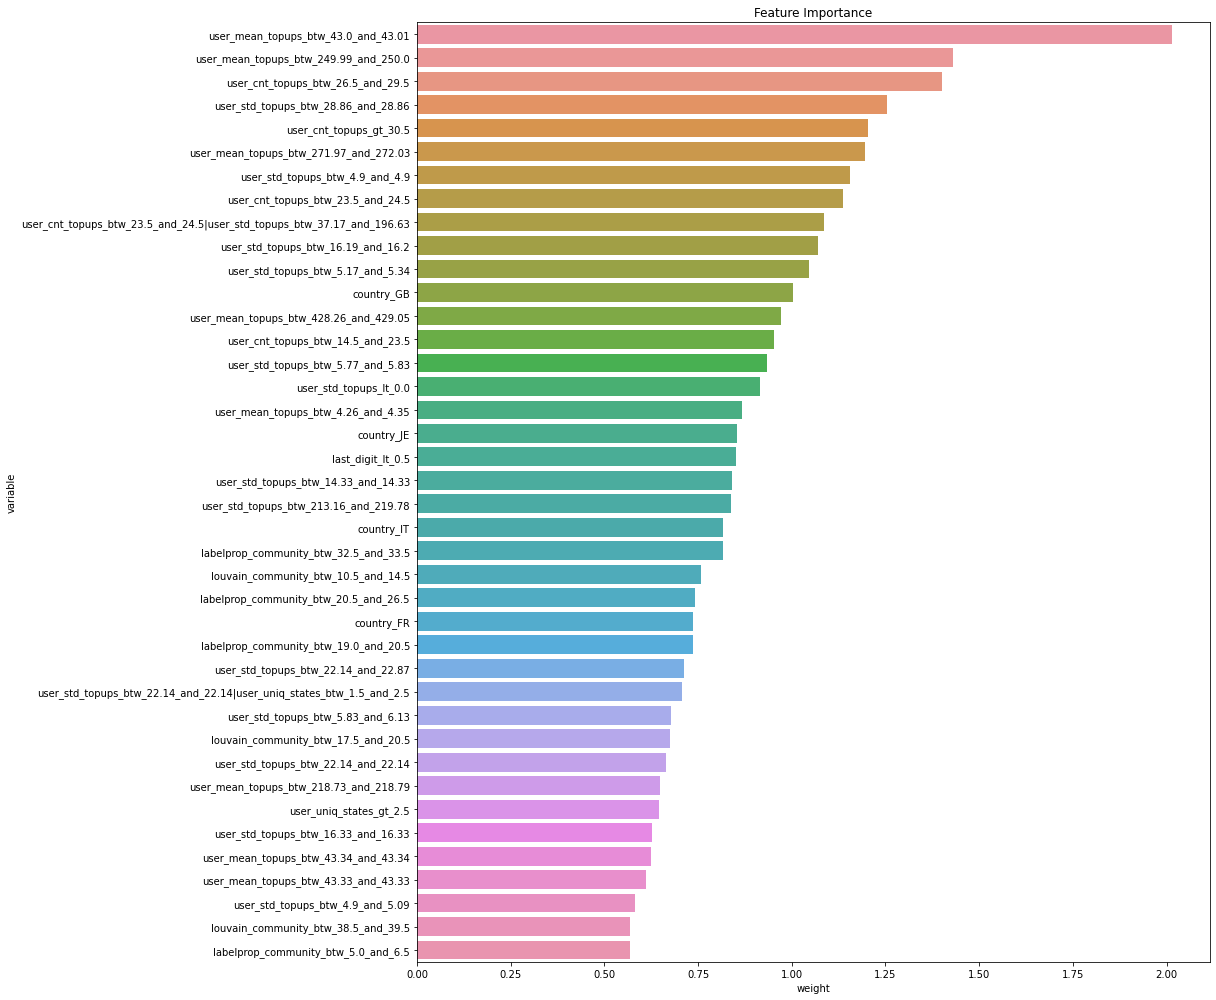

In [ ]:
import seaborn as sns
plt.figure(figsize=(17, 14))
sns.barplot(x="weight", y="variable", data=coefficients.sort_values(by="weight", ascending=False).head(40))
plt.title('Feature Importance')
plt.tight_layout()

# **Explore Interesting Rulesets (RFE-like)**

Ruleset Num. 1



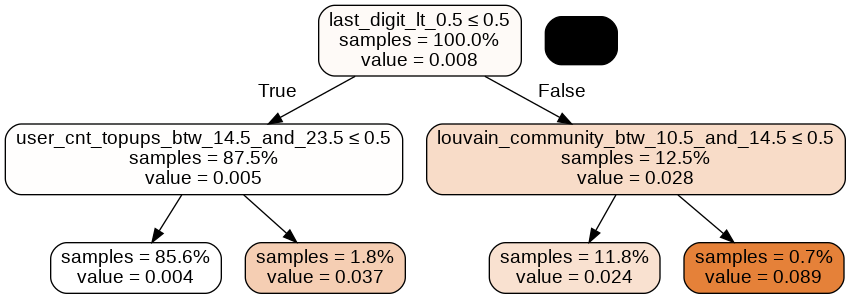


Ruleset Num. 2



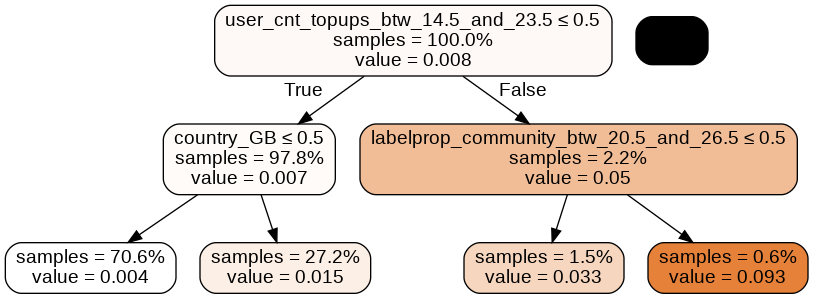

In [ ]:
draw_interactions = get_variables(coefficients, top=25)
i = 0
while len(draw_interactions) > 23:
      i += 1
      print('Ruleset Num. ' + str(i))
      print('')

      top_feature = draw_feature(draw_interactions, max_depth = 2, min_samples_leaf = 1000)
      draw_interactions = list(set(draw_interactions)-set(top_feature))

      print('')
      print(200*'=')

# **Refit the Model on the whole Train and Valid**

In [ ]:
bool_col = X.select_dtypes(include=['bool']).columns
numeric_col = X.select_dtypes(include=['float', 'int']).columns
cat_col = X.select_dtypes(include=['object']).columns

X_enc, X_test_enc, cat_col = encode_float_mdlp(X, X_test, Y, use_features, numeric_col, cat_col)
X_enc, X_test_enc, X_cols, X_test_cols = encode_data_ohe(X_enc, X_test_enc, Y, use_features, bool_col, cat_col)

dtrain = xgb.DMatrix(X_enc, label = Y)
feature_monotones = [1] * (len(X_cols))

params = {'max_depth': 4,
          'eta': 0.1,
          'silent': 1,
          'nthread': 4,
          'seed': 0,
          'tree_method': 'hist',
          'grow_policy': 'lossguide',
          'eval_metric': 'auc',
          'monotone_constraints': '(' + ','.join([str(m) for m in feature_monotones]) + ')'
         }
bst = xgb.train(params, dtrain, num_boost_round = bst_cv.shape[0])

X_enc, X_test_enc, X_cols, X_test_cols = add_interactions(X_enc, X_test_enc, bst, gain_rank_filter = 50)

100%|██████████| 12/12 [17:54<00:00, 89.53s/it]


# **Make predictions for unknown Test**

In [ ]:
clf = SGDClassifier(alpha = 0.0005, penalty='l2', loss='log',
                                      class_weight = 'balanced',
                                      max_iter=3000, random_state = 42)
clf.fit(X_enc, Y)

pred_te = clf.predict_proba(X_test_enc)[:,1]
pred_te_int = (pred_te > np.mean(thresholds)).astype(int)

X_test['prediction'] = pred_te_int

# **Thank you!**